<a href="https://colab.research.google.com/github/lualua0909/DeepLearning-LDS8/blob/main/Week_4/Chapter_7_NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Ex2: IMDB Sentiment Classification with LSTM-Keras**

* Cho dữ liệu https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz
(https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz) (có sẵn trong from
tensorflow.keras.datasets import imdb)
* Xây dựng model dự đoán một nội dung là 1 hay là 0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
%matplotlib inline

In [3]:
max_features = 20000
maxlen = 80 # cut texts after this number of words (among top max_features most
batch_size = 32

In [5]:
print('Loading data...')
(x_train_original, y_train), (x_test_original, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train_original), 'train sequences')
print(len(x_test_original), 'test sequences')

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [6]:
display(x_train_original[:3], y_train[:3])

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

array([1, 0, 0])

In [7]:
display(x_test_original[:3], y_test[:3])

array([list([1, 591, 202, 14, 31, 6, 717, 10, 10, 18142, 10698, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 15387, 38, 32, 25, 7944, 451, 202, 14, 6, 717]),
       list([1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 2679, 23, 1310, 5, 109, 943, 4, 114, 9, 55, 606, 5, 111, 7, 4, 139, 193, 273, 23, 4, 172, 270, 11, 7216, 10626, 4, 8463, 2801, 109, 1603, 21, 4, 22, 3861, 8, 6, 1193, 1330, 10, 10, 4, 105, 987, 35, 841, 16873, 19, 861, 1074, 5, 1987, 17975, 45, 55, 221, 15, 670, 5304, 526, 14, 1069, 4, 405, 5, 2438, 7, 27, 85, 108, 131, 4, 5045, 5304, 3884, 405, 9, 3523, 133, 5, 50, 13, 104, 51, 66, 166, 14, 22, 157, 9, 4, 530, 239, 34, 8463, 2801, 45, 407, 31, 7, 41, 3778, 105, 21, 59, 299, 12, 38, 950, 5, 4521, 15, 45, 629, 488, 2733, 127, 6, 52, 292, 17, 4, 6936, 185, 132, 1988, 5304, 1799, 488, 2693, 47, 6, 392, 173, 4, 2, 4378,

array([0, 1, 1])

In [8]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train_original, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test_original, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [9]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

Build model...


In [12]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
print('Train...')
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=15, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train...
Epoch 1/15
782/782 [==============================] - 503s 636ms/step - loss: 0.4231 - accuracy: 0.8042 - val_loss: 0.3514 - val_accuracy: 0.8454
Epoch 2/15
782/782 [==============================] - 488s 624ms/step - loss: 0.2542 - accuracy: 0.8971 - val_loss: 0.4225 - val_accuracy: 0.8256
Epoch 3/15
782/782 [==============================] - 504s 644ms/step - loss: 0.1605 - accuracy: 0.9388 - val_loss: 0.5281 - val_accuracy: 0.8230
Epoch 4/15
227/782 [=======>......................] - ETA: 5:27 - loss: 0.0883 - accuracy: 0.9692

KeyboardInterrupt: ignored

In [15]:
score, acc = model.evaluate(x_test, y_test,
batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 28s 36ms/step - loss: 0.5466 - accuracy: 0.8209
Test score: 0.5465776920318604
Test accuracy: 0.8209199905395508


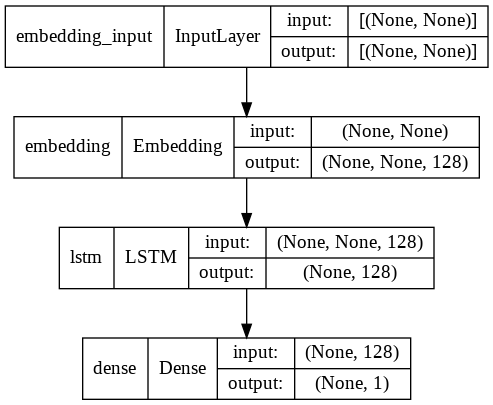

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='LSTM_model_Sentiment.png', show_shapes=True)

In [17]:
#Save the result
from tensorflow.keras.models import load_model
# Creates a HDF5 file 'my_model.h5'
model.save('LSTM_sentiment_model.h5')